In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import Counter
import nltk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from seqeval.metrics import f1_score, classification_report, accuracy_score, recall_score, precision_score
import optuna
from onnxruntime.quantization import quantize_dynamic, QuantType

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### BiLSTMwAttention

#### Seed Setting

```markdown
In here, the code sets the random seed for reproducibility across random, NumPy, and PyTorch operations. This ensures consistent results by fixing the seed for both CPU and GPU computations.
```

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

#### Data Loading

```markdown
In here, the code loads the CoNLL-2003 dataset using the load_dataset function with remote code execution trusted.
```

In [4]:
dataset = load_dataset("conll2003", trust_remote_code=True)

#### Tag Building

```markdown
In here, the code extracts the set of unique NER tags from all dataset splits and creates mappings from tags to indices and vice versa.
```

In [5]:
tag_set = set()
for split in ['train', 'validation', 'test']:
    for tags in dataset[split]['ner_tags']:
        tag_set.update(tags)

In [6]:
tag_names = dataset['train'].features['ner_tags'].feature.names
tagset_size = len(tag_set)

tag2idx = {tag: idx for idx, tag in enumerate(tag_names)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

#### Word Vocabulary Building

```markdown
In here, the code counts the frequency of each word in the training set, selects the most common words up to a specified vocabulary size, and creates mappings from words to indices and vice versa, including special tokens for padding and unknown words.
```

In [7]:
word_counter = Counter()
for tokens in dataset['train']['tokens']:
    word_counter.update([token.lower() for token in tokens])

In [8]:
vocab_size = 100000
special_tokens = ['<PAD>', '<UNK>']

word2idx = {word: idx + len(special_tokens) for idx, (word, _) in enumerate(word_counter.most_common(vocab_size))}
word2idx['<PAD>'] = 0
word2idx['<UNK>'] = 1

idx2word = {idx: word for word, idx in word2idx.items()}

#### Character Vocabulary Building

```markdown
In here, the code constructs a set of unique characters from all tokens across dataset splits and creates mappings from characters to indices and vice versa, including special tokens for padding and unknown characters.
```

In [9]:
char_set = set()
for split in ['train', 'validation', 'test']:
    for tokens in dataset[split]['tokens']:
        for token in tokens:
            char_set.update(token)

In [10]:
char2idx = {char: idx + 2 for idx, char in enumerate(sorted(char_set))}
char2idx['<PAD>'] = 0
char2idx['<UNK>'] = 1

idx2char = {idx: char for char, idx in char2idx.items()}

char_vocab_size = len(char2idx)

In [13]:
print(tagset_size)

9


#### Data Encoding

```markdown
In here, the code defines a function to encode the dataset by converting words and characters to their respective indices, handling padding for both words and characters, and applies this encoding to the training, validation, and test sets.
```

In [47]:
max_len = 50
max_char_len = 10

In [48]:
def encode_data_with_chars(split):
    data = []
    for tokens, tags in zip(dataset[split]['tokens'], dataset[split]['ner_tags']):
        word_ids = [word2idx.get(token.lower(), word2idx['<UNK>']) for token in tokens]
        tag_ids = [tag for tag in tags]
        char_ids = []
        for token in tokens:
            chars = [char2idx.get(c, char2idx['<UNK>']) for c in token]
            if len(chars) > max_char_len:
                chars = chars[:max_char_len]
            else:
                chars += [char2idx['<PAD>']] * (max_char_len - len(chars))
            char_ids.append(chars)
        if len(word_ids) > max_len:
            word_ids = word_ids[:max_len]
            tag_ids = tag_ids[:max_len]
            char_ids = char_ids[:max_len]
        else:
            pad_length = max_len - len(word_ids)
            word_ids += [word2idx['<PAD>']] * pad_length
            tag_ids += [-100] * pad_length
            char_ids += [[char2idx['<PAD>']] * max_char_len] * pad_length
        data.append((word_ids, char_ids, tag_ids))
    return data

In [49]:
train_data = encode_data_with_chars('train')
val_data = encode_data_with_chars('validation')
test_data = encode_data_with_chars('test')

#### Embedding Loading

```markdown
In here, the code loads pre-trained GloVe embeddings from a specified file path, initializes an embedding matrix with these vectors for known words, and assigns random vectors to words not present in the GloVe embeddings.
```

In [50]:
embedding_dim = 200
embeddings_index = {}
glove_file_path = "../../data/glove.6B.200d/glove.6B.200d.txt"

In [51]:
with open(glove_file_path, encoding='utf-8') as f:
    for line in tqdm(f, total=400000):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

100%|██████████| 400000/400000 [00:11<00:00, 35116.33it/s]


In [52]:
embedding_matrix = np.zeros((len(word2idx), embedding_dim))

for word, idx in word2idx.items():
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
        
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)

#### Dataset and DataLoader

```markdown
In here, the code defines a custom dataset class that handles word and character indices along with their corresponding tags. It then creates dataset instances for training, validation, and testing, and wraps them in DataLoader objects for batching.
```

In [53]:
class NERDatasetWithChars(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        word_ids, char_ids, tag_ids = self.data[idx]
        return {
            'words': torch.tensor(word_ids, dtype=torch.long),
            'chars': torch.tensor(char_ids, dtype=torch.long),
            'tags': torch.tensor(tag_ids, dtype=torch.long)
        }

In [54]:
train_dataset = NERDatasetWithChars(train_data)
val_dataset = NERDatasetWithChars(val_data)
test_dataset = NERDatasetWithChars(test_data)

In [55]:
batch_size = 64
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_iter = DataLoader(val_dataset, batch_size=batch_size)
test_iter = DataLoader(test_dataset, batch_size=batch_size)

#### Model Definition

```markdown
In here, the code defines a BiLSTM model with character embeddings and an attention mechanism for Named Entity Recognition. The model includes embedding layers for words and characters, LSTM layers for processing sequences, a multi-head attention layer, and a fully connected layer for tag prediction.

• Word Embeddings
The word embedding layer transforms input words into dense vector representations of fixed size. This layer is initialized with a pre-trained embedding matrix if provided, allowing the model to benefit from semantic information learned from large external corpora. Dropout regularization is applied to word embeddings to prevent overfitting and improve generalization.

• Character Embeddings
To capture subword-level information, the model includes a character embedding layer. Each character in a word is embedded into a dense vector. A bidirectional LSTM processes these character embeddings, producing a combined forward and backward hidden state for each word. This character-level feature is concatenated with the corresponding word embedding, enabling the model to better handle out-of-vocabulary words and learn morphological patterns.

• BiLSTM
The concatenated word and character embeddings are fed into a bidirectional LSTM. This layer captures contextual information by processing sequences in both forward and backward directions. The hidden states from the BiLSTM encode the contextual dependencies of words within the input sequence. A dropout layer and layer normalization are applied to the BiLSTM output to stabilize training and reduce overfitting.

• Multi-Head Attention
The multi-head attention layer operates on the BiLSTM outputs, allowing the model to attend to different parts of the sequence when producing a representation for each word. This mechanism enhances the model’s ability to capture long-range dependencies and focus on important tokens. The attention output is combined with the BiLSTM output via a residual connection, further improving representation quality and preserving the original sequential information.

• Fully Connected Layer
The combined output from the residual connection is passed through a fully connected layer, mapping it to the tag space. This final layer is responsible for producing the tag predictions for each token in the sequence, such as entity labels for NER tasks.
```

In [56]:
class BiLSTMwA(nn.Module):
    def __init__(self, vocab_size, char_vocab_size, word_embedding_dim, char_embedding_dim,
                 char_hidden_dim, hidden_dim, tagset_size, embeddings=None, dropout=0.5):
        super(BiLSTMwA, self).__init__()
        
        # Embedding Layer for Word w/ Padding Index for '<PAD>'
        self.word_embedding = nn.Embedding(vocab_size, word_embedding_dim, padding_idx=word2idx['<PAD>'])
        # Parameter Layer for Word Embeddings Initialization w/ Pre-Trained Embeddings (if provided)
        if embeddings is not None:
            self.word_embedding.weight = nn.Parameter(embeddings)
            self.word_embedding.weight.requires_grad = True # Gradient Enabling for Fine-Tuning
        # Dropout Layer for Word Regularization
        self.word_dropout = nn.Dropout(dropout)
        
        # Embedding Layer for Character w/ Padding Index for '<PAD>'
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim, padding_idx=char2idx['<PAD>'])
        # UniLSTM Layer for Character Feature Extraction
        self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim, num_layers=1,
                                 bidirectional=True, batch_first=True)
        # Dropout Layer for Character Regularization
        self.char_dropout = nn.Dropout(dropout)
        
        # BiLSTM Layer for Contextual Word and Character Representation
        self.bilstm = nn.LSTM(word_embedding_dim + 2 * char_hidden_dim, hidden_dim // 2,
                              num_layers=2, bidirectional=True, batch_first=True, dropout=dropout)
        # Normalization Layer for Word and Character Stabilization
        self.layer_norm = nn.LayerNorm(hidden_dim)
        # Dropout Layer for Word and Character Regularization
        self.lstm_dropout = nn.Dropout(dropout)
        # Multi-Head Attention Layer for Contextual Word and Character Feature Extraction
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8, dropout=dropout, batch_first=True)
        # Fully Connected Layer for Word and Character → Tag Space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
    
    
    def forward(self, words, chars):
        # Word Embeddings of Input Words
        word_embeds = self.word_embedding(words)
        # Dropout of Word Embeddings
        word_embeds = self.word_dropout(word_embeds)

        batch_size, seq_len, char_len = chars.size()
        chars = chars.view(batch_size * seq_len, char_len)
        # Character Embeddings of Input Characters
        char_embeds = self.char_embedding(chars)
        # UniLSTM of Character Embeddings 
        char_lstm_out, _ = self.char_lstm(char_embeds)
        # Concatenation of Forward and Backward Character Hidden States of Last Time Step
        char_hidden = torch.cat((char_lstm_out[:, -1, :char_lstm_out.size(2)//2],
                                 char_lstm_out[:, -1, char_lstm_out.size(2)//2:]), dim=1)
        # Dropout of Character Hidden States
        char_hidden = self.char_dropout(char_hidden)
        # Reshaping of Character Hidden States → Word Embeddings
        char_hidden = char_hidden.view(batch_size, seq_len, -1)
        
        # Concatenation of Word Embeddings and Character Hidden States
        combined = torch.cat((word_embeds, char_hidden), dim=2)
        # BiLSTM of Word Embeddings and Character Hidden States
        lstm_out, _ = self.bilstm(combined)
        # Normalization of BiLSTM Output
        lstm_out = self.layer_norm(lstm_out)
        # Dropout of BiLSTM Output
        lstm_out = self.lstm_dropout(lstm_out)
        # Attention of BiLSTM Output
        attn_output, attn_weights = self.attention(lstm_out, lstm_out, lstm_out)
        # Residual Connection: BiLSTM Output + Attention Output
        combined_output = lstm_out + attn_output
        # Transformation of Residual Connection → Tag Space
        tag_space = self.hidden2tag(combined_output)
        return tag_space

#### Training Function

```markdown
In here, the code defines a function to train the model for one epoch. It processes each batch, computes the loss, performs backpropagation, updates the model parameters, and calculates the training accuracy.
```

In [57]:
def train_epoch(net, train_iter, criterion, optimizer, device):
    net.train()
    total_loss = 0
    total_acc = 0

    for batch in tqdm(train_iter, desc="Training", leave=False):
        words = batch['words'].to(device)
        chars = batch['chars'].to(device)
        tags = batch['tags'].to(device)

        optimizer.zero_grad()
        emissions = net(words, chars)

        loss = criterion(emissions.view(-1, emissions.size(-1)), tags.view(-1))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(emissions, dim=2)
        acc = (preds == tags).float().sum() / (tags != -100).sum()
        total_acc += acc.item()

    avg_loss = total_loss / len(train_iter)
    avg_acc = total_acc / len(train_iter)
    return avg_loss, avg_acc

#### Evaluation Function

```markdown
In here, the code defines a function to evaluate the model on a validation set. It computes the loss and accuracy without updating the model parameters and collects all predictions and true labels for further metric calculations.
```

In [58]:
def evaluate_epoch(net, val_iter, criterion, device):
    net.eval()
    total_loss = 0
    total_acc = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_iter, desc="Evaluating", leave=False):
            words = batch['words'].to(device)
            chars = batch['chars'].to(device)
            tags = batch['tags'].to(device)

            emissions = net(words, chars)

            loss = criterion(emissions.view(-1, emissions.size(-1)), tags.view(-1))
            total_loss += loss.item()

            _, preds = torch.max(emissions, dim=2)
            acc = (preds == tags).float().sum() / (tags != -100).sum()
            total_acc += acc.item()

            preds = preds.cpu().numpy()
            tags = tags.cpu().numpy()

            for pred_seq, tag_seq in zip(preds, tags):
                pred_tags = []
                true_tags = []
                for p, t in zip(pred_seq, tag_seq):
                    if t != -100:
                        pred_tags.append(idx2tag[p])
                        true_tags.append(idx2tag[t])
                all_preds.append(pred_tags)
                all_labels.append(true_tags)

    avg_loss = total_loss / len(val_iter)
    avg_acc = total_acc / len(val_iter)
    return avg_loss, avg_acc, all_preds, all_labels

#### Hyperparameter Tuning

```markdown
In here, the code utilizes Optuna to perform hyperparameter tuning. It defines an objective function that suggests hyperparameters, initializes the model with these parameters, trains the model for a set number of epochs with early stopping based on validation F1 score, and returns the best F1 score achieved. The study is then optimized over a specified number of trials to find the best hyperparameters.
```

In [59]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    hidden_dim = trial.suggest_int('hidden_dim', 256, 1024, step=128)
    dropout = trial.suggest_float('dropout', 0.3, 0.7, step=0.1)

    net = BiLSTMwA(
        vocab_size=vocab_size,
        char_vocab_size=char_vocab_size,
        word_embedding_dim=embedding_dim,
        char_embedding_dim=50,
        char_hidden_dim=50,
        hidden_dim=hidden_dim,
        tagset_size=tagset_size,
        embeddings=embedding_matrix,
        dropout=dropout
    )
    net.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    optimizer = optim.Adam(net.parameters(), lr=lr)

    best_val_f1 = 0.0
    counter = 0
    patience = 2
    num_epochs_tuning = 5

    for epoch in range(num_epochs_tuning):
        train_loss, train_acc = train_epoch(net, train_iter, criterion, optimizer, device)
        val_loss, val_acc, all_preds, all_labels = evaluate_epoch(net, val_iter, criterion, device)
        val_f1 = f1_score(all_labels, all_preds)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(net.state_dict(), "best_model.pth")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break
    return best_val_f1

In [60]:
# study = optuna.create_study(direction='maximize', study_name='NER_Hyperparam_Tuning')
# study.optimize(objective, n_trials=20)
# best_trial = study.best_trial    
# best_params = best_trial.params

In [61]:
# print("\nBest Hyperparameters:")
# for key, value in best_params.items():
#     print(f"{key}: {value}")

#### Final Training

```markdown
In here, the code initializes the BiLSTM model with the best hyperparameters obtained from tuning, sets up the optimizer and loss function, and trains the model for a specified number of epochs with early stopping based on validation F1 score. It also records training and validation metrics for visualization and saves the best-performing model.
```

In [62]:
net = BiLSTMwA(
    vocab_size=vocab_size,
    char_vocab_size=char_vocab_size,
    word_embedding_dim=embedding_dim,
    char_embedding_dim=50,
    # hidden_dim=best_params['hidden_dim'],
    hidden_dim=256,
    char_hidden_dim=50,
    tagset_size=tagset_size,
    embeddings=embedding_matrix,
    # dropout=best_params['dropout']
    dropout=0.4
)
net.to(device)

BiLSTMwA(
  (word_embedding): Embedding(100000, 200, padding_idx=0)
  (word_dropout): Dropout(p=0.4, inplace=False)
  (char_embedding): Embedding(87, 50, padding_idx=0)
  (char_lstm): LSTM(50, 50, batch_first=True, bidirectional=True)
  (char_dropout): Dropout(p=0.4, inplace=False)
  (bilstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lstm_dropout): Dropout(p=0.4, inplace=False)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (hidden2tag): Linear(in_features=256, out_features=9, bias=True)
)

In [63]:
criterion = nn.CrossEntropyLoss(ignore_index=-100)
# optimizer = optim.AdamW(net.parameters(), lr=best_params['lr'], weight_decay=0.01)
optimizer = optim.AdamW(net.parameters(), lr=0.002071759505536834, weight_decay=0.01)
num_epochs = 15
num_epochs_used = 0

best_val_f1 = 0.0
counter = 0
patience = 3

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [64]:
for epoch in range(num_epochs):
    num_epochs_used += 1
    print(f"\nepoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train_epoch(net, train_iter, criterion, optimizer, device)
    val_loss, val_acc, all_preds, all_labels = evaluate_epoch(net, val_iter, criterion, device)
    val_f1 = f1_score(all_labels, all_preds)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}")
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(net.state_dict(), "best_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            break


epoch 1/15


train loss: 0.2450, train acc: 0.9299, val acc: 0.9754

epoch 2/15


train loss: 0.0729, train acc: 0.9789, val acc: 0.9793

epoch 3/15


train loss: 0.0474, train acc: 0.9864, val acc: 0.9804

epoch 4/15


train loss: 0.0354, train acc: 0.9898, val acc: 0.9826

epoch 5/15


train loss: 0.0250, train acc: 0.9926, val acc: 0.9827

epoch 6/15


train loss: 0.0192, train acc: 0.9943, val acc: 0.9836

epoch 7/15


train loss: 0.0157, train acc: 0.9953, val acc: 0.9827

epoch 8/15


train loss: 0.0134, train acc: 0.9961, val acc: 0.9772

epoch 9/15


train loss: 0.0107, train acc: 0.9969, val acc: 0.9781


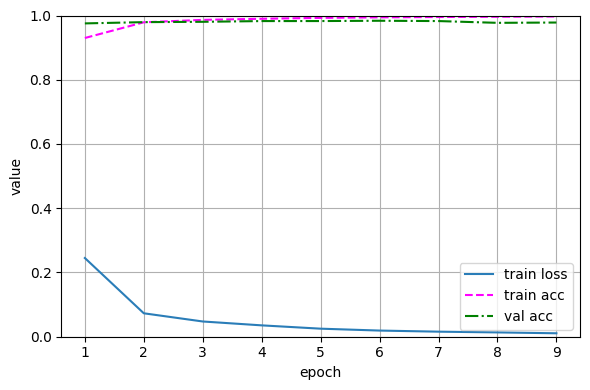

In [65]:
epochs_range = range(1, num_epochs_used + 1)
plt.figure(figsize=(6, 4))

plt.plot(epochs_range, train_losses, label='train loss', linestyle='-', color='#2a7db8')
plt.plot(epochs_range, train_accuracies, label='train acc', linestyle='--', color='magenta')
plt.plot(epochs_range, val_accuracies, label='val acc', linestyle='-.', color='green')
plt.xlabel('epoch')
plt.ylabel('value')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

plt.show()

#### Evaluation Metrics

```markdown
In here, the code defines a function to calculate and display evaluation metrics such as accuracy, precision, recall, F1 score, and a detailed classification report on the test set. It then invokes this function to evaluate the trained model.
```

In [66]:
net.load_state_dict(torch.load("best_model.pth"))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2432\1080333206.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

In [67]:
def cal_metrics(net, test_iter):
    net.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_iter, desc="Testing"):
            words = batch['words'].to(device)
            chars = batch['chars'].to(device)
            tags = batch['tags'].to(device)
            
            emissions = net(words, chars)
            _, preds = torch.max(emissions, dim=2)
            
            preds = preds.cpu().numpy()
            tags = tags.cpu().numpy()
            
            for pred_seq, tag_seq in zip(preds, tags):
                pred_tags = []
                true_tags = []
                for p, t in zip(pred_seq, tag_seq):
                    if t != -100:
                        pred_tags.append(idx2tag[p])
                        true_tags.append(idx2tag[t])
                all_preds.append(pred_tags)
                all_labels.append(true_tags)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("\nClassification Report:\n", report)

    return None

In [68]:
cal_metrics(net, test_iter)

Testing: 100%|██████████| 54/54 [00:00<00:00, 66.67it/s]


Accuracy:  0.9682
Precision: 0.8105
Recall:    0.8433
F1 Score:  0.8266

Classification Report:
               precision    recall  f1-score   support

         LOC       0.91      0.85      0.88      1656
        MISC       0.75      0.73      0.74       701
         ORG       0.75      0.79      0.77      1658
         PER       0.81      0.94      0.87      1580

   micro avg       0.81      0.84      0.83      5595
   macro avg       0.80      0.83      0.81      5595
weighted avg       0.81      0.84      0.83      5595



#### Prediction

```markdown
In here, the code defines a function to predict NER tags for a given input sentence. It tokenizes the sentence, converts tokens and characters to their respective indices, feeds them into the model to obtain predictions, and then maps the predicted indices back to their corresponding NER tags. Finally, it prints out each token with its predicted tag.
```

In [69]:
def predict_ner(net, sentence, word2idx, char2idx, idx2tag):
    tokens = nltk.word_tokenize(sentence)
    device = torch.device('cpu')
    net.to(device)
    net.eval()
    max_len = 50
    max_char_len = 10
    word_ids = []
    char_ids = []
    
    for token in tokens:
        word_id = word2idx.get(token.lower(), word2idx['<UNK>'])
        word_ids.append(word_id)
        chars_of_token = [char2idx.get(c, char2idx['<UNK>']) for c in token]
        if len(chars_of_token) > max_char_len:
            chars_of_token = chars_of_token[:max_char_len]
        else:
            chars_of_token += [char2idx['<PAD>']] * (max_char_len - len(chars_of_token))
        char_ids.append(chars_of_token)
    
    if len(word_ids) > max_len:
        word_ids = word_ids[:max_len]
        char_ids = char_ids[:max_len]
    else:
        pad_length = max_len - len(word_ids)
        word_ids += [word2idx['<PAD>']] * pad_length
        char_ids += [[char2idx['<PAD>']] * max_char_len] * pad_length
    
    word_tensor = torch.tensor([word_ids], dtype=torch.long, device=device)
    char_tensor = torch.tensor([char_ids], dtype=torch.long, device=device)
    
    with torch.no_grad():
        emissions = net(word_tensor, char_tensor)
        _, preds = torch.max(emissions, dim=2)
    preds = preds.squeeze(0).cpu().numpy()
    real_length = min(len(tokens), max_len)
    pred_tags = [idx2tag[preds[i]] for i in range(real_length)]
    
    return tokens, pred_tags


In [70]:
tokens, predicted_tags = predict_ner(net, "John lives in New York", word2idx, char2idx, idx2tag)
for token, tag in zip(tokens, predicted_tags):
    print(token, tag)

John B-PER
lives O
in O
New B-LOC
York I-LOC


#### ONNX Exporting

In [71]:
# def net_to_onnx(net, word2idx, char2idx, onnx_file_path="model.onnx"):
#     device = torch.device('cpu')
#     net.to(device)
#     net.eval()
#     max_len = 50
#     max_char_len = 10
#     word_ids = [word2idx['<PAD>']] * max_len
#     char_ids = [[char2idx['<PAD>']] * max_char_len] * max_len
#     word_tensor = torch.tensor([word_ids], dtype=torch.long, device=device)
#     char_tensor = torch.tensor([char_ids], dtype=torch.long, device=device)
    
#     torch.onnx.export(
#         net, 
#         (word_tensor, char_tensor),
#         onnx_file_path, 
#         export_params=True,
#         opset_version=13,
#         input_names=["word_ids", "char_ids"],
#         output_names=["emissions"],
#         dynamic_axes={
#             "word_ids": {0: "batch_size", 1: "seq_length"},
#             "char_ids": {0: "batch_size", 1: "seq_length", 2: "char_length"},
#             "emissions": {0: "batch_size", 1: "seq_length"}
#         }
#     )
#     return None

# net_to_onnx(net, word2idx, char2idx, "model.onnx")

In [72]:
# from onnxruntime.quantization import quantize_dynamic, QuantType

# def quantize_onnx(input_model_path, output_model_path):
#     quantize_dynamic(
#         model_input=input_model_path,
#         model_output=output_model_path,
#         weight_type=QuantType.QInt8
#     )
#     return None

# original_model_path = "model.onnx"
# quantized_model_path = "model-q.onnx"
# quantize_onnx(original_model_path, quantized_model_path)